<a href="https://colab.research.google.com/github/vageeshmaiya/Deep-Learning-based-Battery-Synthetic-Data/blob/main/Deep_tcn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep TCN

#### Installing Darts

In [ ]:
pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 424 kB 35.1 MB/s 
     |████████████████████████████████| 11.2 MB 44.7 MB/s 
     |████████████████████████████████| 1.8 MB 50.5 MB/s 
     |████████████████████████████████| 76.6 MB 65.4 MB/s 
     |████████████████████████████████| 9.8 MB 51.3 MB/s 
     |████████████████████████████████| 705 kB 56.4 MB/s 
     |████████████████████████████████| 44 kB 2.3 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 1.6 MB 51.7 MB/s 
     |████████████████████████████████| 957 kB 53.7 MB/s 
     |████████████████████████████████| 5.9 MB 40.0 MB/s 
     |████████████████████████████████| 419 kB 49.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
  Attempting uninstall: tensorbo

In [ ]:
from os.path import dirname, basename
from os import getcwd
import sys

In [ ]:
def fix_pythonpath_if_working_locally():
    """Add the parent path to pythonpath if current working dir is darts/examples"""
    cwd = getcwd()
    if basename(cwd) == 'examples':
        sys.path.insert(0, dirname(cwd))

In [ ]:
import pandas as pd

from darts.models import TCNModel
import darts.utils.timeseries_generation as tg
from darts.utils.likelihood_models import GaussianLikelihood
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

import matplotlib.pyplot as plt


#### Uploading Dataset

1. Make sure to upload the dataset to be used in google drive
2. Make the necessary changes in the path by copying the path of the dataset uploaded

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/dataset4.csv"
df = pd.read_csv(path)

In [ ]:
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4129 entries, 0 to 4128
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date_Time            4129 non-null   datetime64[ns]
 1   Charge_Capacity(Ah)  4129 non-null   float64       
 2   Voltage(V)           4129 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 96.9 KB


In [ ]:
# Coloumns can be dropped as per requirement
# Uncomment to drop required coloumns
#df = df.drop('Charge_Capacity(Ah)',axis=1)                                               

In [ ]:
df.info

<bound method DataFrame.info of                Date_Time  Voltage(V)
0    2018-01-27 15:48:10    3.393696
1    2018-01-27 15:50:10    3.394385
2    2018-01-27 15:52:10    3.394773
3    2018-01-27 15:54:10    3.395056
4    2018-01-27 15:56:10    3.395251
...                  ...         ...
4124 2018-02-02 09:16:10    4.400018
4125 2018-02-02 09:18:10    4.400045
4126 2018-02-02 09:20:10    4.399933
4127 2018-02-02 09:22:10    4.400000
4128 2018-02-02 09:24:10    4.399972

[4129 rows x 2 columns]>

#### Creating timeseries data and Scaling the data

In [ ]:
ser = TimeSeries.from_dataframe(df=df,time_col="Date_Time")

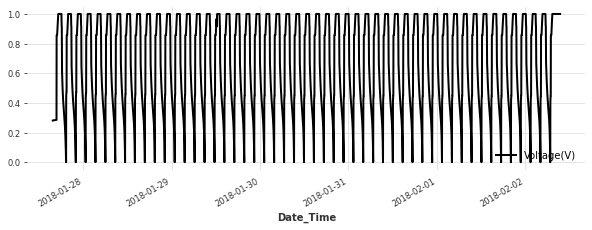

In [ ]:
scaler_en = Scaler() #scaling
series_en_transformed = scaler_en.fit_transform(ser)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(pd.Timestamp('1/30/2018  10:26:10 AM'))
plt.figure(figsize=(10, 3))
series_en_transformed.plot()

In [ ]:
deeptcn = TCNModel(
    dropout=0,
    batch_size=16,
    n_epochs=100,
    optimizer_kwargs={'lr': 1e-3}, 
    random_state=42,
    input_chunk_length=300,
    output_chunk_length=12,
    kernel_size=3,
    num_filters=4,
    likelihood=GaussianLikelihood())

deeptcn.fit(series=train_en_transformed, verbose=True)

Training: 0it [00:00, ?it/s]

Predicting: 106it [00:00, ?it/s]

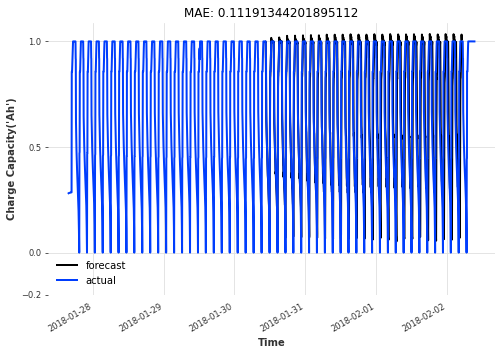

In [ ]:
from darts.metrics import mae
def eval_model(model):
    pred_series = model.predict(n=2000)
    plt.figure(figsize=(8,5))
    pred_series.plot(label='forecast')
    series_en_transformed.plot(label='actual')
    plt.xlabel('Time')
    plt.ylabel("Charge Capacity('Ah')")
    plt.yticks([-0.2,0,0.5,1])
    plt.title('MAE: {}'.format(mae(pred_series, val_en_transformed)))
    plt.savefig("darts_deeptcn_6_cycles.pdf",bbox_inches="tight")
    plt.legend()
    
    
eval_model(deeptcn)

#### Backtesting

In [ ]:
backtest_en = deeptcn.historical_forecasts(
    series=series_en_transformed,
    num_samples=50,
    start=0.7,
    forecast_horizon=5,
    stride=5,
    retrain=False,
    verbose=True)


  0%|          | 0/248 [00:00<?, ?it/s]

Predicting: 106it [00:00, ?it/s]


  0%|          | 1/248 [00:00<01:22,  2.99it/s]

Predicting: 106it [00:00, ?it/s]


  1%|          | 2/248 [00:00<01:27,  2.81it/s]

Predicting: 106it [00:00, ?it/s]


  1%|          | 3/248 [00:00<01:16,  3.21it/s]

Predicting: 106it [00:00, ?it/s]


  2%|▏         | 4/248 [00:01<00:59,  4.10it/s]

Predicting: 106it [00:00, ?it/s]


  2%|▏         | 5/248 [00:01<00:49,  4.86it/s]

Predicting: 106it [00:00, ?it/s]


  2%|▏         | 6/248 [00:01<00:44,  5.49it/s]

Predicting: 106it [00:00, ?it/s]


  3%|▎         | 7/248 [00:01<00:39,  6.05it/s]

Predicting: 106it [00:00, ?it/s]


  3%|▎         | 8/248 [00:01<00:36,  6.66it/s]

Predicting: 106it [00:00, ?it/s]


  4%|▎         | 9/248 [00:01<00:35,  6.75it/s]

Predicting: 106it [00:00, ?it/s]


  4%|▍         | 10/248 [00:01<00:33,  7.14it/s]

Predicting: 106it [00:00, ?it/s]


  4%|▍         | 11/248 [00:02<00:32,  7.25it/s]

Predicting: 106it [00:00, ?it/s]


  5%|▍         | 12/248 [00:02<00:32,  7.34it/s]

Predicting: 106it [00:00, ?it/s]


  5%|▌         | 13/248 [00:02<00:32,  7.28it/s]

Predicting: 106it [00:00, ?it/s]


  6%|▌         | 14/248 [00:02<00:30,  7.63it/s]

Predicting: 106it [00:00, ?it/s]


  6%|▌         | 15/248 [00:02<00:31,  7.50it/s]

Predicting: 106it [00:00, ?it/s]


  6%|▋         | 16/248 [00:02<00:30,  7.69it/s]

Predicting: 106it [00:00, ?it/s]


  7%|▋         | 17/248 [00:02<00:29,  7.79it/s]

Predicting: 106it [00:00, ?it/s]


  7%|▋         | 18/248 [00:02<00:29,  7.81it/s]

Predicting: 106it [00:00, ?it/s]


  8%|▊         | 19/248 [00:03<00:28,  7.90it/s]

Predicting: 106it [00:00, ?it/s]


  8%|▊         | 20/248 [00:03<00:30,  7.37it/s]

Predicting: 106it [00:00, ?it/s]


  8%|▊         | 21/248 [00:03<00:31,  7.24it/s]

Predicting: 106it [00:00, ?it/s]


  9%|▉         | 22/248 [00:03<00:31,  7.26it/s]

Predicting: 106it [00:00, ?it/s]


  9%|▉         | 23/248 [00:03<00:31,  7.11it/s]

Predicting: 106it [00:00, ?it/s]


 10%|▉         | 24/248 [00:03<00:31,  7.18it/s]

Predicting: 106it [00:00, ?it/s]


 10%|█         | 25/248 [00:04<00:43,  5.11it/s]

Predicting: 106it [00:00, ?it/s]


 10%|█         | 26/248 [00:04<00:40,  5.50it/s]

Predicting: 106it [00:00, ?it/s]


 11%|█         | 27/248 [00:04<00:37,  5.95it/s]

Predicting: 106it [00:00, ?it/s]


 11%|█▏        | 28/248 [00:04<00:34,  6.38it/s]

Predicting: 106it [00:00, ?it/s]


 12%|█▏        | 29/248 [00:04<00:32,  6.72it/s]

Predicting: 106it [00:00, ?it/s]


 12%|█▏        | 30/248 [00:04<00:31,  6.96it/s]

Predicting: 106it [00:00, ?it/s]


 12%|█▎        | 31/248 [00:04<00:30,  7.17it/s]

Predicting: 106it [00:00, ?it/s]


 13%|█▎        | 32/248 [00:05<00:29,  7.36it/s]

Predicting: 106it [00:00, ?it/s]


 13%|█▎        | 33/248 [00:05<00:28,  7.47it/s]

Predicting: 106it [00:00, ?it/s]


 14%|█▎        | 34/248 [00:05<00:28,  7.59it/s]

Predicting: 106it [00:00, ?it/s]


 14%|█▍        | 35/248 [00:05<00:28,  7.36it/s]

Predicting: 106it [00:00, ?it/s]


 15%|█▍        | 36/248 [00:05<00:27,  7.62it/s]

Predicting: 106it [00:00, ?it/s]


 15%|█▍        | 37/248 [00:05<00:27,  7.68it/s]

Predicting: 106it [00:00, ?it/s]


 15%|█▌        | 38/248 [00:05<00:26,  7.79it/s]

Predicting: 106it [00:00, ?it/s]


 16%|█▌        | 39/248 [00:05<00:26,  7.86it/s]

Predicting: 106it [00:00, ?it/s]


 16%|█▌        | 40/248 [00:06<00:29,  7.14it/s]

Predicting: 106it [00:00, ?it/s]


 17%|█▋        | 41/248 [00:06<00:29,  7.08it/s]

Predicting: 106it [00:00, ?it/s]


 17%|█▋        | 42/248 [00:06<00:28,  7.25it/s]

Predicting: 106it [00:00, ?it/s]


 17%|█▋        | 43/248 [00:06<00:28,  7.10it/s]

Predicting: 106it [00:00, ?it/s]


 18%|█▊        | 44/248 [00:06<00:28,  7.26it/s]

Predicting: 106it [00:00, ?it/s]


 18%|█▊        | 45/248 [00:06<00:29,  6.86it/s]

Predicting: 106it [00:00, ?it/s]


 19%|█▊        | 46/248 [00:06<00:28,  7.10it/s]

Predicting: 106it [00:00, ?it/s]


 19%|█▉        | 47/248 [00:07<00:27,  7.40it/s]

Predicting: 106it [00:00, ?it/s]


 19%|█▉        | 48/248 [00:07<00:26,  7.60it/s]

Predicting: 106it [00:00, ?it/s]


 20%|█▉        | 49/248 [00:07<00:25,  7.74it/s]

Predicting: 106it [00:00, ?it/s]


 20%|██        | 50/248 [00:07<00:25,  7.88it/s]

Predicting: 106it [00:00, ?it/s]


 21%|██        | 51/248 [00:07<00:26,  7.55it/s]

Predicting: 106it [00:00, ?it/s]


 21%|██        | 52/248 [00:07<00:27,  7.21it/s]

Predicting: 106it [00:00, ?it/s]


 21%|██▏       | 53/248 [00:07<00:28,  6.91it/s]

Predicting: 106it [00:00, ?it/s]


 22%|██▏       | 54/248 [00:08<00:29,  6.66it/s]

Predicting: 106it [00:00, ?it/s]


 22%|██▏       | 55/248 [00:08<00:29,  6.44it/s]

Predicting: 106it [00:00, ?it/s]


 23%|██▎       | 56/248 [00:08<00:29,  6.41it/s]

Predicting: 106it [00:00, ?it/s]


 23%|██▎       | 57/248 [00:08<00:28,  6.71it/s]

Predicting: 106it [00:00, ?it/s]


 23%|██▎       | 58/248 [00:08<00:28,  6.62it/s]

Predicting: 106it [00:00, ?it/s]


 24%|██▍       | 59/248 [00:08<00:29,  6.51it/s]

Predicting: 106it [00:00, ?it/s]


 24%|██▍       | 60/248 [00:08<00:27,  6.93it/s]

Predicting: 106it [00:00, ?it/s]


 25%|██▍       | 61/248 [00:09<00:25,  7.27it/s]

Predicting: 106it [00:00, ?it/s]


 25%|██▌       | 62/248 [00:09<00:24,  7.47it/s]

Predicting: 106it [00:00, ?it/s]


 25%|██▌       | 63/248 [00:09<00:24,  7.64it/s]

Predicting: 106it [00:00, ?it/s]


 26%|██▌       | 64/248 [00:09<00:23,  7.76it/s]

Predicting: 106it [00:00, ?it/s]


 26%|██▌       | 65/248 [00:09<00:23,  7.83it/s]

Predicting: 106it [00:00, ?it/s]


 27%|██▋       | 66/248 [00:09<00:22,  7.93it/s]

Predicting: 106it [00:00, ?it/s]


 27%|██▋       | 67/248 [00:09<00:23,  7.78it/s]

Predicting: 106it [00:00, ?it/s]


 27%|██▋       | 68/248 [00:09<00:23,  7.81it/s]

Predicting: 106it [00:00, ?it/s]


 28%|██▊       | 69/248 [00:10<00:22,  7.88it/s]

Predicting: 106it [00:00, ?it/s]


 28%|██▊       | 70/248 [00:10<00:22,  7.98it/s]

Predicting: 106it [00:00, ?it/s]


 29%|██▊       | 71/248 [00:10<00:21,  8.05it/s]

Predicting: 106it [00:00, ?it/s]


 29%|██▉       | 72/248 [00:10<00:21,  8.09it/s]

Predicting: 106it [00:00, ?it/s]


 29%|██▉       | 73/248 [00:10<00:23,  7.60it/s]

Predicting: 106it [00:00, ?it/s]


 30%|██▉       | 74/248 [00:10<00:23,  7.42it/s]

Predicting: 106it [00:00, ?it/s]


 30%|███       | 75/248 [00:10<00:24,  7.19it/s]

Predicting: 106it [00:00, ?it/s]


 31%|███       | 76/248 [00:11<00:22,  7.52it/s]

Predicting: 106it [00:00, ?it/s]


 31%|███       | 77/248 [00:11<00:22,  7.76it/s]

Predicting: 106it [00:00, ?it/s]


 31%|███▏      | 78/248 [00:11<00:21,  7.79it/s]

Predicting: 106it [00:00, ?it/s]


 32%|███▏      | 79/248 [00:11<00:21,  7.95it/s]

Predicting: 106it [00:00, ?it/s]


 32%|███▏      | 80/248 [00:11<00:20,  8.07it/s]

Predicting: 106it [00:00, ?it/s]


 33%|███▎      | 81/248 [00:11<00:23,  7.23it/s]

Predicting: 106it [00:00, ?it/s]


 33%|███▎      | 82/248 [00:11<00:24,  6.91it/s]

Predicting: 106it [00:00, ?it/s]


 33%|███▎      | 83/248 [00:11<00:23,  6.96it/s]

Predicting: 106it [00:00, ?it/s]


 34%|███▍      | 84/248 [00:12<00:24,  6.82it/s]

Predicting: 106it [00:00, ?it/s]


 34%|███▍      | 85/248 [00:12<00:26,  6.26it/s]

Predicting: 106it [00:00, ?it/s]


 35%|███▍      | 86/248 [00:12<00:25,  6.24it/s]

Predicting: 106it [00:00, ?it/s]


 35%|███▌      | 87/248 [00:12<00:26,  6.18it/s]

Predicting: 106it [00:00, ?it/s]


 35%|███▌      | 88/248 [00:12<00:23,  6.67it/s]

Predicting: 106it [00:00, ?it/s]


 36%|███▌      | 89/248 [00:12<00:23,  6.69it/s]

Predicting: 106it [00:00, ?it/s]


 36%|███▋      | 90/248 [00:13<00:23,  6.83it/s]

Predicting: 106it [00:00, ?it/s]


 37%|███▋      | 91/248 [00:13<00:22,  7.00it/s]

Predicting: 106it [00:00, ?it/s]


 37%|███▋      | 92/248 [00:13<00:21,  7.31it/s]

Predicting: 106it [00:00, ?it/s]


 38%|███▊      | 93/248 [00:13<00:20,  7.57it/s]

Predicting: 106it [00:00, ?it/s]


 38%|███▊      | 94/248 [00:13<00:21,  7.24it/s]

Predicting: 106it [00:00, ?it/s]


 38%|███▊      | 95/248 [00:13<00:22,  6.91it/s]

Predicting: 106it [00:00, ?it/s]


 39%|███▊      | 96/248 [00:13<00:22,  6.72it/s]

Predicting: 106it [00:00, ?it/s]


 39%|███▉      | 97/248 [00:14<00:22,  6.85it/s]

Predicting: 106it [00:00, ?it/s]


 40%|███▉      | 98/248 [00:14<00:21,  6.98it/s]

Predicting: 106it [00:00, ?it/s]


 40%|███▉      | 99/248 [00:14<00:21,  7.07it/s]

Predicting: 106it [00:00, ?it/s]


 40%|████      | 100/248 [00:14<00:20,  7.20it/s]

Predicting: 106it [00:00, ?it/s]


 41%|████      | 101/248 [00:14<00:19,  7.39it/s]

Predicting: 106it [00:00, ?it/s]


 41%|████      | 102/248 [00:14<00:19,  7.55it/s]

Predicting: 106it [00:00, ?it/s]


 42%|████▏     | 103/248 [00:14<00:18,  7.82it/s]

Predicting: 106it [00:00, ?it/s]


 42%|████▏     | 104/248 [00:14<00:19,  7.35it/s]

Predicting: 106it [00:00, ?it/s]


 42%|████▏     | 105/248 [00:15<00:19,  7.43it/s]

Predicting: 106it [00:00, ?it/s]


 43%|████▎     | 106/248 [00:15<00:18,  7.71it/s]

Predicting: 106it [00:00, ?it/s]


 43%|████▎     | 107/248 [00:15<00:17,  7.90it/s]

Predicting: 106it [00:00, ?it/s]


 44%|████▎     | 108/248 [00:15<00:17,  8.01it/s]

Predicting: 106it [00:00, ?it/s]


 44%|████▍     | 109/248 [00:15<00:17,  8.09it/s]

Predicting: 106it [00:00, ?it/s]


 44%|████▍     | 110/248 [00:15<00:18,  7.61it/s]

Predicting: 106it [00:00, ?it/s]


 45%|████▍     | 111/248 [00:15<00:17,  7.80it/s]

Predicting: 106it [00:00, ?it/s]


 45%|████▌     | 112/248 [00:15<00:17,  7.99it/s]

Predicting: 106it [00:00, ?it/s]


 46%|████▌     | 113/248 [00:16<00:16,  7.97it/s]

Predicting: 106it [00:00, ?it/s]


 46%|████▌     | 114/248 [00:16<00:16,  7.97it/s]

Predicting: 106it [00:00, ?it/s]


 46%|████▋     | 115/248 [00:16<00:17,  7.66it/s]

Predicting: 106it [00:00, ?it/s]


 47%|████▋     | 116/248 [00:16<00:16,  7.89it/s]

Predicting: 106it [00:00, ?it/s]


 47%|████▋     | 117/248 [00:16<00:16,  7.97it/s]

Predicting: 106it [00:00, ?it/s]


 48%|████▊     | 118/248 [00:16<00:15,  8.13it/s]

Predicting: 106it [00:00, ?it/s]


 48%|████▊     | 119/248 [00:16<00:16,  7.91it/s]

Predicting: 106it [00:00, ?it/s]


 48%|████▊     | 120/248 [00:16<00:16,  7.80it/s]

Predicting: 106it [00:00, ?it/s]


 49%|████▉     | 121/248 [00:17<00:16,  7.92it/s]

Predicting: 106it [00:00, ?it/s]


 49%|████▉     | 122/248 [00:17<00:15,  7.97it/s]

Predicting: 106it [00:00, ?it/s]


 50%|████▉     | 123/248 [00:17<00:15,  8.09it/s]

Predicting: 106it [00:00, ?it/s]


 50%|█████     | 124/248 [00:17<00:15,  8.14it/s]

Predicting: 106it [00:00, ?it/s]


 50%|█████     | 125/248 [00:17<00:14,  8.22it/s]

Predicting: 106it [00:00, ?it/s]


 51%|█████     | 126/248 [00:17<00:15,  8.13it/s]

Predicting: 106it [00:00, ?it/s]


 51%|█████     | 127/248 [00:17<00:15,  8.06it/s]

Predicting: 106it [00:00, ?it/s]


 52%|█████▏    | 128/248 [00:17<00:14,  8.14it/s]

Predicting: 106it [00:00, ?it/s]


 52%|█████▏    | 129/248 [00:18<00:14,  8.16it/s]

Predicting: 106it [00:00, ?it/s]


 52%|█████▏    | 130/248 [00:18<00:14,  7.89it/s]

Predicting: 106it [00:00, ?it/s]


 53%|█████▎    | 131/248 [00:18<00:14,  8.06it/s]

Predicting: 106it [00:00, ?it/s]


 53%|█████▎    | 132/248 [00:18<00:14,  7.97it/s]

Predicting: 106it [00:00, ?it/s]


 54%|█████▎    | 133/248 [00:18<00:15,  7.53it/s]

Predicting: 106it [00:00, ?it/s]


 54%|█████▍    | 134/248 [00:18<00:15,  7.41it/s]

Predicting: 106it [00:00, ?it/s]


 54%|█████▍    | 135/248 [00:18<00:15,  7.42it/s]

Predicting: 106it [00:00, ?it/s]


 55%|█████▍    | 136/248 [00:19<00:14,  7.57it/s]

Predicting: 106it [00:00, ?it/s]


 55%|█████▌    | 137/248 [00:19<00:14,  7.68it/s]

Predicting: 106it [00:00, ?it/s]


 56%|█████▌    | 138/248 [00:19<00:14,  7.67it/s]

Predicting: 106it [00:00, ?it/s]


 56%|█████▌    | 139/248 [00:19<00:14,  7.78it/s]

Predicting: 106it [00:00, ?it/s]


 56%|█████▋    | 140/248 [00:19<00:13,  7.95it/s]

Predicting: 106it [00:00, ?it/s]


 57%|█████▋    | 141/248 [00:19<00:13,  7.96it/s]

Predicting: 106it [00:00, ?it/s]


 57%|█████▋    | 142/248 [00:19<00:13,  7.67it/s]

Predicting: 106it [00:00, ?it/s]


 58%|█████▊    | 143/248 [00:19<00:13,  7.66it/s]

Predicting: 106it [00:00, ?it/s]


 58%|█████▊    | 144/248 [00:20<00:14,  7.22it/s]

Predicting: 106it [00:00, ?it/s]


 58%|█████▊    | 145/248 [00:20<00:14,  7.23it/s]

Predicting: 106it [00:00, ?it/s]


 59%|█████▉    | 146/248 [00:20<00:14,  7.01it/s]

Predicting: 106it [00:00, ?it/s]


 59%|█████▉    | 147/248 [00:20<00:14,  6.95it/s]

Predicting: 106it [00:00, ?it/s]


 60%|█████▉    | 148/248 [00:20<00:14,  7.09it/s]

Predicting: 106it [00:00, ?it/s]


 60%|██████    | 149/248 [00:20<00:13,  7.28it/s]

Predicting: 106it [00:00, ?it/s]


 60%|██████    | 150/248 [00:20<00:13,  7.34it/s]

Predicting: 106it [00:00, ?it/s]


 61%|██████    | 151/248 [00:21<00:13,  7.45it/s]

Predicting: 106it [00:00, ?it/s]


 61%|██████▏   | 152/248 [00:21<00:12,  7.56it/s]

Predicting: 106it [00:00, ?it/s]


 62%|██████▏   | 153/248 [00:21<00:12,  7.72it/s]

Predicting: 106it [00:00, ?it/s]


 62%|██████▏   | 154/248 [00:21<00:12,  7.74it/s]

Predicting: 106it [00:00, ?it/s]


 62%|██████▎   | 155/248 [00:21<00:11,  7.87it/s]

Predicting: 106it [00:00, ?it/s]


 63%|██████▎   | 156/248 [00:21<00:11,  7.84it/s]

Predicting: 106it [00:00, ?it/s]


 63%|██████▎   | 157/248 [00:21<00:11,  7.63it/s]

Predicting: 106it [00:00, ?it/s]


 64%|██████▎   | 158/248 [00:21<00:11,  7.84it/s]

Predicting: 106it [00:00, ?it/s]


 64%|██████▍   | 159/248 [00:22<00:11,  7.98it/s]

Predicting: 106it [00:00, ?it/s]


 65%|██████▍   | 160/248 [00:22<00:11,  7.94it/s]

Predicting: 106it [00:00, ?it/s]


 65%|██████▍   | 161/248 [00:22<00:10,  8.00it/s]

Predicting: 106it [00:00, ?it/s]


 65%|██████▌   | 162/248 [00:22<00:10,  7.89it/s]

Predicting: 106it [00:00, ?it/s]


 66%|██████▌   | 163/248 [00:22<00:11,  7.68it/s]

Predicting: 106it [00:00, ?it/s]


 66%|██████▌   | 164/248 [00:22<00:10,  7.84it/s]

Predicting: 106it [00:00, ?it/s]


 67%|██████▋   | 165/248 [00:22<00:10,  7.83it/s]

Predicting: 106it [00:00, ?it/s]


 67%|██████▋   | 166/248 [00:22<00:10,  7.73it/s]

Predicting: 106it [00:00, ?it/s]


 67%|██████▋   | 167/248 [00:23<00:11,  7.08it/s]

Predicting: 106it [00:00, ?it/s]


 68%|██████▊   | 168/248 [00:23<00:10,  7.37it/s]

Predicting: 106it [00:00, ?it/s]


 68%|██████▊   | 169/248 [00:23<00:10,  7.45it/s]

Predicting: 106it [00:00, ?it/s]


 69%|██████▊   | 170/248 [00:23<00:11,  6.86it/s]

Predicting: 106it [00:00, ?it/s]


 69%|██████▉   | 171/248 [00:23<00:10,  7.11it/s]

Predicting: 106it [00:00, ?it/s]


 69%|██████▉   | 172/248 [00:23<00:10,  7.10it/s]

Predicting: 106it [00:00, ?it/s]


 70%|██████▉   | 173/248 [00:23<00:10,  7.03it/s]

Predicting: 106it [00:00, ?it/s]


 70%|███████   | 174/248 [00:24<00:10,  7.18it/s]

Predicting: 106it [00:00, ?it/s]


 71%|███████   | 175/248 [00:24<00:09,  7.33it/s]

Predicting: 106it [00:00, ?it/s]


 71%|███████   | 176/248 [00:24<00:09,  7.43it/s]

Predicting: 106it [00:00, ?it/s]


 71%|███████▏  | 177/248 [00:24<00:09,  7.56it/s]

Predicting: 106it [00:00, ?it/s]


 72%|███████▏  | 178/248 [00:24<00:09,  7.31it/s]

Predicting: 106it [00:00, ?it/s]


 72%|███████▏  | 179/248 [00:24<00:09,  7.29it/s]

Predicting: 106it [00:00, ?it/s]


 73%|███████▎  | 180/248 [00:24<00:09,  7.38it/s]

Predicting: 106it [00:00, ?it/s]


 73%|███████▎  | 181/248 [00:25<00:08,  7.54it/s]

Predicting: 106it [00:00, ?it/s]


 73%|███████▎  | 182/248 [00:25<00:08,  7.51it/s]

Predicting: 106it [00:00, ?it/s]


 74%|███████▍  | 183/248 [00:25<00:09,  7.03it/s]

Predicting: 106it [00:00, ?it/s]


 74%|███████▍  | 184/248 [00:25<00:08,  7.16it/s]

Predicting: 106it [00:00, ?it/s]


 75%|███████▍  | 185/248 [00:25<00:08,  7.16it/s]

Predicting: 106it [00:00, ?it/s]


 75%|███████▌  | 186/248 [00:25<00:09,  6.83it/s]

Predicting: 106it [00:00, ?it/s]


 75%|███████▌  | 187/248 [00:25<00:08,  6.96it/s]

Predicting: 106it [00:00, ?it/s]


 76%|███████▌  | 188/248 [00:26<00:08,  7.20it/s]

Predicting: 106it [00:00, ?it/s]


 76%|███████▌  | 189/248 [00:26<00:08,  7.28it/s]

Predicting: 106it [00:00, ?it/s]


 77%|███████▋  | 190/248 [00:26<00:07,  7.47it/s]

Predicting: 106it [00:00, ?it/s]


 77%|███████▋  | 191/248 [00:26<00:07,  7.69it/s]

Predicting: 106it [00:00, ?it/s]


 77%|███████▋  | 192/248 [00:26<00:07,  7.82it/s]

Predicting: 106it [00:00, ?it/s]


 78%|███████▊  | 193/248 [00:26<00:06,  7.93it/s]

Predicting: 106it [00:00, ?it/s]


 78%|███████▊  | 194/248 [00:26<00:07,  7.65it/s]

Predicting: 106it [00:00, ?it/s]


 79%|███████▊  | 195/248 [00:26<00:07,  7.01it/s]

Predicting: 106it [00:00, ?it/s]


 79%|███████▉  | 196/248 [00:27<00:07,  6.95it/s]

Predicting: 106it [00:00, ?it/s]


 79%|███████▉  | 197/248 [00:27<00:07,  7.26it/s]

Predicting: 106it [00:00, ?it/s]


 80%|███████▉  | 198/248 [00:27<00:06,  7.52it/s]

Predicting: 106it [00:00, ?it/s]


 80%|████████  | 199/248 [00:27<00:06,  7.77it/s]

Predicting: 106it [00:00, ?it/s]


 81%|████████  | 200/248 [00:27<00:06,  7.91it/s]

Predicting: 106it [00:00, ?it/s]


 81%|████████  | 201/248 [00:27<00:05,  7.89it/s]

Predicting: 106it [00:00, ?it/s]


 81%|████████▏ | 202/248 [00:27<00:05,  7.70it/s]

Predicting: 106it [00:00, ?it/s]


 82%|████████▏ | 203/248 [00:27<00:05,  7.82it/s]

Predicting: 106it [00:00, ?it/s]


 82%|████████▏ | 204/248 [00:28<00:05,  8.00it/s]

Predicting: 106it [00:00, ?it/s]


 83%|████████▎ | 205/248 [00:28<00:05,  7.71it/s]

Predicting: 106it [00:00, ?it/s]


 83%|████████▎ | 206/248 [00:28<00:05,  7.89it/s]

Predicting: 106it [00:00, ?it/s]


 83%|████████▎ | 207/248 [00:28<00:05,  7.97it/s]

Predicting: 106it [00:00, ?it/s]


 84%|████████▍ | 208/248 [00:28<00:04,  8.05it/s]

Predicting: 106it [00:00, ?it/s]


 84%|████████▍ | 209/248 [00:28<00:04,  7.82it/s]

Predicting: 106it [00:00, ?it/s]


 85%|████████▍ | 210/248 [00:28<00:05,  7.27it/s]

Predicting: 106it [00:00, ?it/s]


 85%|████████▌ | 211/248 [00:29<00:05,  6.97it/s]

Predicting: 106it [00:00, ?it/s]


 85%|████████▌ | 212/248 [00:29<00:04,  7.24it/s]

Predicting: 106it [00:00, ?it/s]


 86%|████████▌ | 213/248 [00:29<00:04,  7.40it/s]

Predicting: 106it [00:00, ?it/s]


 86%|████████▋ | 214/248 [00:29<00:04,  6.89it/s]

Predicting: 106it [00:00, ?it/s]


 87%|████████▋ | 215/248 [00:29<00:04,  7.09it/s]

Predicting: 106it [00:00, ?it/s]


 87%|████████▋ | 216/248 [00:29<00:04,  7.39it/s]

Predicting: 106it [00:00, ?it/s]


 88%|████████▊ | 217/248 [00:29<00:04,  7.42it/s]

Predicting: 106it [00:00, ?it/s]


 88%|████████▊ | 218/248 [00:29<00:03,  7.55it/s]

Predicting: 106it [00:00, ?it/s]


 88%|████████▊ | 219/248 [00:30<00:03,  7.72it/s]

Predicting: 106it [00:00, ?it/s]


 89%|████████▊ | 220/248 [00:30<00:03,  7.88it/s]

Predicting: 106it [00:00, ?it/s]


 89%|████████▉ | 221/248 [00:30<00:03,  7.81it/s]

Predicting: 106it [00:00, ?it/s]


 90%|████████▉ | 222/248 [00:30<00:03,  7.99it/s]

Predicting: 106it [00:00, ?it/s]


 90%|████████▉ | 223/248 [00:30<00:03,  8.03it/s]

Predicting: 106it [00:00, ?it/s]


 90%|█████████ | 224/248 [00:30<00:02,  8.02it/s]

Predicting: 106it [00:00, ?it/s]


 91%|█████████ | 225/248 [00:30<00:02,  8.03it/s]

Predicting: 106it [00:00, ?it/s]


 91%|█████████ | 226/248 [00:30<00:02,  7.89it/s]

Predicting: 106it [00:00, ?it/s]


 92%|█████████▏| 227/248 [00:31<00:02,  7.91it/s]

Predicting: 106it [00:00, ?it/s]


 92%|█████████▏| 228/248 [00:31<00:02,  7.58it/s]

Predicting: 106it [00:00, ?it/s]


 92%|█████████▏| 229/248 [00:31<00:02,  7.26it/s]

Predicting: 106it [00:00, ?it/s]


 93%|█████████▎| 230/248 [00:31<00:02,  7.48it/s]

Predicting: 106it [00:00, ?it/s]


 93%|█████████▎| 231/248 [00:31<00:02,  7.66it/s]

Predicting: 106it [00:00, ?it/s]


 94%|█████████▎| 232/248 [00:31<00:02,  7.54it/s]

Predicting: 106it [00:00, ?it/s]


 94%|█████████▍| 233/248 [00:31<00:01,  7.78it/s]

Predicting: 106it [00:00, ?it/s]


 94%|█████████▍| 234/248 [00:32<00:01,  7.82it/s]

Predicting: 106it [00:00, ?it/s]


 95%|█████████▍| 235/248 [00:32<00:01,  7.86it/s]

Predicting: 106it [00:00, ?it/s]


 95%|█████████▌| 236/248 [00:32<00:01,  8.01it/s]

Predicting: 106it [00:00, ?it/s]


 96%|█████████▌| 237/248 [00:32<00:01,  8.12it/s]

Predicting: 106it [00:00, ?it/s]


 96%|█████████▌| 238/248 [00:32<00:01,  8.29it/s]

Predicting: 106it [00:00, ?it/s]


 96%|█████████▋| 239/248 [00:32<00:01,  8.25it/s]

Predicting: 106it [00:00, ?it/s]


 97%|█████████▋| 240/248 [00:32<00:00,  8.32it/s]

Predicting: 106it [00:00, ?it/s]


 97%|█████████▋| 241/248 [00:32<00:00,  8.22it/s]

Predicting: 106it [00:00, ?it/s]


 98%|█████████▊| 242/248 [00:33<00:00,  7.94it/s]

Predicting: 106it [00:00, ?it/s]


 98%|█████████▊| 243/248 [00:33<00:00,  5.55it/s]

Predicting: 106it [00:00, ?it/s]


 98%|█████████▊| 244/248 [00:33<00:01,  3.50it/s]

Predicting: 106it [00:00, ?it/s]


 99%|█████████▉| 245/248 [00:34<00:00,  3.42it/s]

Predicting: 106it [00:00, ?it/s]


 99%|█████████▉| 246/248 [00:34<00:00,  4.13it/s]

Predicting: 106it [00:00, ?it/s]


100%|█████████▉| 247/248 [00:34<00:00,  4.83it/s]

Predicting: 106it [00:00, ?it/s]


100%|██████████| 248/248 [00:34<00:00,  7.11it/s]


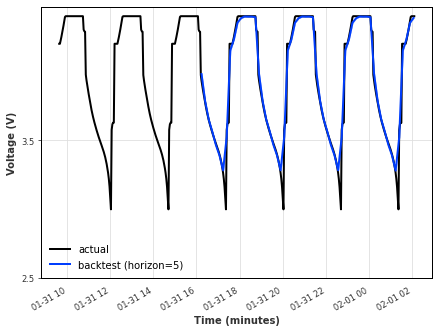

In [ ]:
import numpy as np
plt.figure(figsize=(7,5),edgecolor="black")
ax = plt.axes()
scaler_en.inverse_transform(series_en_transformed)[2695:3190].plot(label='actual')
scaler_en.inverse_transform(backtest_en)[0:60].plot(
    label='backtest (horizon=5)', 
    low_quantile=0.01, 
    high_quantile=0.99)
plt.legend();
plt.xlabel('Time (minutes)')
plt.ylabel('Voltage (V)')
plt.yticks(np.arange(2.5,4))
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.savefig("ChargeCapacity_Dataset4_horizon5_deepTCN.pdf",bbox_inches="tight")

#### Calculating mae values

In [ ]:
mae(series_en_transformed, backtest_en)

0.03449658197545381

In [ ]:
horizon = [10,30,50,80,100,200,300,400,500,600,700,800,900,1000]
mae_voltage = [0.03300610430736358,0.040354819261249765,0.045392651863248125,0.055605198909112356,0.06144693328235384,0.08786146566232034,0.11741502293934725,0.16236704465543755,0.1863151008859987,0.21096878454408405,0.24203894657461486,0.2657503843443756,0.28393446129061506,0.3218624875454618]
mae_chargecapacity = [0.027861769864558072,0.029298309573684456,0.029334995674947188,0.02938976354178376,0.041822742772139626,0.05828229633404029,0.06588024810703844,0.07160108807626284,0.07633627964995077,0.08148715309189944,0.08113592440154707,0.08935655658901619,0.10657968729560184,0.12860550478967625]

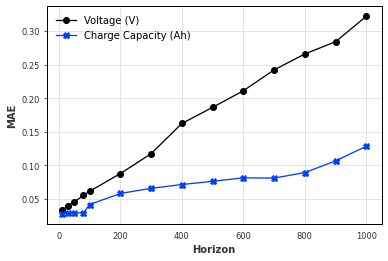

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.spines['top'].set_visible(True)
ax.spines['right'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.plot(horizon,mae_voltage,marker = "o",label = "Voltage (V)")
ax.plot(horizon,mae_chargecapacity,marker = "X",label = "Charge Capacity (Ah)")
ax.set_xlabel('Horizon')
ax.set_ylabel('MAE')
plt.legend()
plt.savefig("darts_deeptcn_mae_vs_horizon_dataset4.pdf",bbox_inches="tight")

